# Práctica 1

Miembros del grupo:
- Jorge Casan Vázquez
- Alvaro Ferro
- Luis Llera

Para empezar nos importaremos las librerías necesarias para poder leer los archivos y realizar los cálculos y representaciones gráficas necesarias

In [1]:
import pandas as pd
%matplotlib inline
import numpy as pnp
import seaborn as sns

## Leer los archivos

In [2]:
df = pd.read_csv('prosperLoanData.csv')

In [3]:
print('The DataSet has {} rows and {} columns'.format(df.shape[0], df.shape[1]))

The DataSet has 113937 rows and 81 columns


In [4]:
df.columns

Index(['ListingKey', 'ListingNumber', 'ListingCreationDate', 'CreditGrade',
       'Term', 'LoanStatus', 'ClosedDate', 'BorrowerAPR', 'BorrowerRate',
       'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss',
       'EstimatedReturn', 'ProsperRating (numeric)', 'ProsperRating (Alpha)',
       'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState',
       'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration',
       'IsBorrowerHomeowner', 'CurrentlyInGroup', 'GroupKey',
       'DateCreditPulled', 'CreditScoreRangeLower', 'CreditScoreRangeUpper',
       'FirstRecordedCreditLine', 'CurrentCreditLines', 'OpenCreditLines',
       'TotalCreditLinespast7years', 'OpenRevolvingAccounts',
       'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries',
       'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'Availa

En nuestra opinión las variables más importantes de nuestro dataset, son las siguientes:

- **LoanStatus**: Esta variable representa el estado acual del prestamo. Puede tener las siguientes categorías: 'Cancelled', 'Chargedoff', 'Completed', 'Current', 'Default', 'FinalPaymentInProgress' y 'PastDue'. Hemos de destacar que este último vendrá acompañado de un 'Delicuency bucket'


- **LoanMonthsSinceOrigination**: Esta variable representa el número de meses transcurridos desde la fecha de originación.


- **LoanFirstDefaultedCycleNumber**: Esta variable representa el ciclo del préstamo hasta que incurrió en Default.


- **LoanCurrentDaysDelinquent**: Esta variable representa el número de días en las que el préstamo incurrío en mora


Puesto que nuestro análisis se va a basar en analizar el porcentaje de préstamos 'malos' es imprescindible analizar las variables que expresen el actual estado del préstamo ya que de ello dependerán como se defina nuestra **Performance y Sample Window**.

Sobre esta base vamos a poder realizar predicciones a futuro, las cuales con diferentes técnicas de Machine Learning, expuestas en la **práctica 3**, se explican detalladamente.

# Performance & Sample Window

La variable **LoanOriginationDate** es interesante analizarla para ver cuántos préstamos se formalizan cada año. 


- Llama la atención el repunte considerable una vez pasada la crisis, en donde 2013-2014 se registraron un gran crecimiento de préstamos por parte de la entidad.


- En el intervalo 2009-2010 apenas se formalizaron préstamos, esto puede deberse a los cambios regulatorios que experimentaron las entidades financieras por las exigencias de la EBA (European Banking Authority) y los cumplimientos de capital y liquidez regulatorios de Basilea III.


- Pese a la crisis financiera sufrida concluimos que el crecimiento de los préstamos formalizados ha sido positivo y con tendencia alcista.

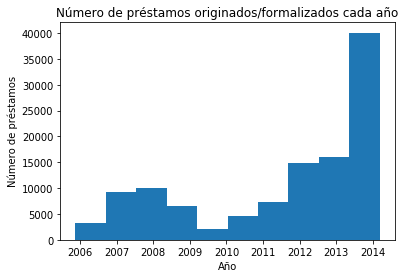

In [5]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
x = pd.to_datetime(df.LoanOriginationDate.str[:10])
plt.hist(x)
plt.title('Número de préstamos originados/formalizados cada año')
plt.xlabel('Año')
plt.ylabel('Número de préstamos')
plt.show()

## TO DO

El primer TO DO es seleccionar qué variable emplearemos como variable objetivo. Existen dos opciones:
- Opción A: **LoanStatus** 
- Opción B: **LoanFirstDefaultedCycleNumber** 

Nos quedamos con la Opción B. Nuestra variable objetivo será **LoanFirstDefaultedCycleNumber**, ya que como se ha explicado antes, nos interesa analizar la *maturity* del préstamo, ya que importa un histórico de información y como ha evolucionado el préstamo desde su fecha de originación.

**LoanStatus** solo refleja el último status del préstamo. No podemos basarnos en dicha columna para configurar el *TARGET*

## Vintage analysis

El análisis VINTAGE proporciona un análisis mucho mejor y más depurado sobre el rendimiento de los préstamos que otros análisis, por ello realizaremos las primeras trasformaciones de las variables con el fin de llegar a soluciones interesantes

In [5]:
df.LoanFirstDefaultedCycleNumber.head(5)

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: LoanFirstDefaultedCycleNumber, dtype: float64

La idea que tenemos con el análisis VINTAGE es tener un porcentaje de malos préstamos, expresados a través de la **BAD RATE**, para ello los pasos que hemos seguido han sido los siguientes:

- 1º paso: La variable **LoanMonthsSinceOrigination** la establecemos como años transcurridos desde que se originó el préstamo
- 2º paso: Nos creamos la variable **LoanFirstDefaultedCycleNumberQ** para ver el primer trimestre en donde el préstamo icurrió en impago.
- 3º paso: Nuestro **df_vintage** recogerá los años transcurridos desde que se origininó el préstamo así como el número de préstamos originados cada año, con la clara finalidad de poder compararlos.
- 4º paso: Definimos nuestra **BAD RATE**, la cual será el cociente entre el número de de préstamos malos y el total de préstamos

In [9]:
df['LoanMonthsSinceOriginationY'] = (df.LoanMonthsSinceOrigination / 12).round()
df['LoanFirstDefaultedCycleNumberQ'] = 4 * (df.LoanFirstDefaultedCycleNumber / 4).round()
df_vintage = df.groupby('LoanMonthsSinceOriginationY').agg({'LoanMonthsSinceOriginationY': 'size'})\
                                                     .rename(columns={'LoanMonthsSinceOriginationY': 'N_loans'})\
                                                     .reset_index()

df['bad_aux'] = ~df['LoanFirstDefaultedCycleNumber'].isna()
df_def_per_cycle = pd.DataFrame(df.groupby(['LoanMonthsSinceOriginationY', 'LoanFirstDefaultedCycleNumberQ'])['bad_aux'].sum().groupby(level=[0]).cumsum()).reset_index()
df_def_per_cycle.columns = df_def_per_cycle.columns[:-1].tolist() +  ['N_bads']

df_vintage = df_vintage.merge(df_def_per_cycle, on='LoanMonthsSinceOriginationY')
df_vintage['BR'] = 100. * df_vintage['N_bads'] / df_vintage['N_loans']

df_vintage.head(8)

,LoanMonthsSinceOriginationY,N_loans,LoanFirstDefaultedCycleNumberQ,N_bads,BR
0,0.0,29808,4.0,1.0,0.003355
1,0.0,29808,8.0,3.0,0.010064
2,1.0,21134,0.0,3.0,0.014195
3,1.0,21134,4.0,18.0,0.085171
4,1.0,21134,8.0,462.0,2.186051
5,1.0,21134,12.0,622.0,2.943125
6,1.0,21134,16.0,712.0,3.368979
7,2.0,20122,0.0,8.0,0.039757


Nos creamos una *TABLA DINÁMICA* para ver la relación entre el primer trimestre de imapgo del préstamo y los años en donde el préstamo está vivo desde la fecha de originación

In [10]:
df_vin_pvt = df_vintage.pivot(index='LoanMonthsSinceOriginationY', columns='LoanFirstDefaultedCycleNumberQ', values='BR')
df_vin_pvt

LoanFirstDefaultedCycleNumberQ,0.0,4.0,8.0,12.0,16.0,20.0,24.0,28.0,32.0,36.0,40.0,44.0
LoanMonthsSinceOriginationY,,,,,,,,,,,,
0.0,NaN,0.003355,0.010064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,0.014195,0.085171,2.186051,2.943125,3.368979,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,0.039757,0.462181,5.342411,8.180101,12.160819,13.850512,15.132691,15.321539,15.326508,NaN,NaN,NaN
3.0,0.497830,0.931836,5.731427,8.424815,12.215982,14.003064,16.504978,17.870820,19.019658,19.211131,19.223896,NaN
4.0,1.117222,1.460983,4.417326,6.170505,8.765899,10.072190,12.220694,13.234789,14.575455,15.177037,15.830182,NaN
5.0,0.861009,NaN,6.150062,9.963100,14.022140,15.252153,17.958180,19.311193,20.541205,21.156212,22.017220,NaN
6.0,1.280445,1.851079,8.427279,12.985386,20.215727,23.291580,27.446068,29.485038,31.649269,32.713987,34.036186,34.043145
7.0,1.988015,2.872634,13.297822,18.814801,25.292495,28.659755,33.368211,35.708171,38.761533,40.017122,41.396366,NaN
8.0,1.276596,2.723404,11.177305,15.829787,22.978723,25.929078,29.900709,31.659574,34.269504,35.659574,36.964539,NaN


Representamos gráficamente los mismos resultados de la tabla dinámica creada y observamos que los **préstamos más antiguos** son los que presentan más **DEFAULT**

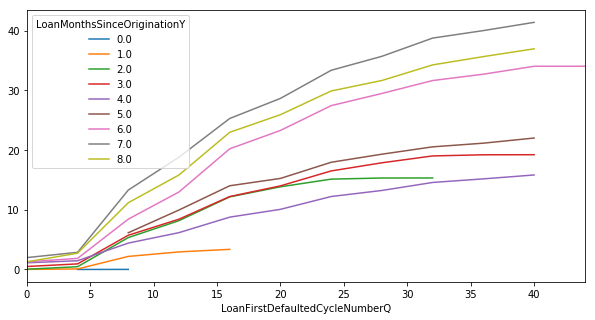

In [11]:
df_vin_pvt.transpose().plot(figsize=(10, 5))

## Good, bad, indeterminate definition

## TO DO

Vamos a implementar nuestra **PERFORMANCE WINDOW**, así como el fraude asociado, la columna de **INDETERMINADOS** y los préstamos **MALOS**

In [10]:
def generate_pop_flags_custom(df, PW_size, TH_fraud=4):
    """Vamos a realizar una pequeña modificación en la anterior funcionç
    con objetivo de que se devuelva una variable nueva
    
    Args:
        df: Pandas DataFrame with the input data
        PW_size: Int Performance window size (months)
        TH_fraud: Int number of months used as treshold for fraud
        
    Returns:
        Pandas DataFrame with the columns that capture
        fraud, bad and indeterminate
    """
    res = pd.DataFrame()
    #PW maturity
    res['PW'] = df.LoanMonthsSinceOrigination >= PW_size
    #handle fraud 
    res['fraud'] = df.LoanFirstDefaultedCycleNumber <= TH_fraud
    #bad definition
    res['bad'] = (df.LoanFirstDefaultedCycleNumber > TH_fraud) & (df.LoanFirstDefaultedCycleNumber <= PW_size)
    #indeterminates
    res['indeterm'] = (df.LoanFirstDefaultedCycleNumber > PW_size)
    res.loc[(res.bad == 0) & (df.LoanCurrentDaysDelinquent > 30), 'indeterm'] = True
    return df.join(res)

A través de la función custom lo que vamos a hacer es probar diferentes parámetros para la Performance Windows y el umbral del fraude

In [11]:
first = generate_pop_flags_custom(df, 6)
first[['PW', 'fraud', 'bad', 'indeterm']].sum()

PW          87315
fraud         562
bad          1096
indeterm    16955
dtype: int64

In [12]:
second = generate_pop_flags_custom(df, 8, 6)
second[['PW', 'fraud', 'bad', 'indeterm']].sum()

PW          81069
fraud        1658
bad          1834
indeterm    16215
dtype: int64

In [13]:
third = generate_pop_flags_custom(df, 10, 4)
third[['PW', 'fraud', 'bad', 'indeterm']].sum()

PW          75441
fraud         562
bad          4737
indeterm    13314
dtype: int64

In [14]:
fourth = generate_pop_flags_custom(df, 10, 6)
fourth[['PW', 'fraud', 'bad', 'indeterm']].sum()

PW          75441
fraud        1658
bad          3641
indeterm    14408
dtype: int64

In [15]:
fifth = generate_pop_flags_custom(df, 12)
fifth[['PW', 'fraud', 'bad', 'indeterm']].sum()

PW          71036
fraud         562
bad          6397
indeterm    11654
dtype: int64

Ahora se aplica la funcion original con los parametros que hemos comprobado previamente
Esta funcion modificada el dataframe original, asi que hay que correrla debajo de la custom

In [16]:
generate_pop_flags_custom(df, 6).head(3)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,LoanMonthsSinceOriginationY,LoanFirstDefaultedCycleNumberQ,bad_aux,PW,fraud,bad,indeterm
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.158,0.138,...,0,0.0,258,6.0,NaN,False,True,False,False,False
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.092,0.082,...,0,0.0,1,0.0,NaN,False,False,False,False,False
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.275,0.240,...,0,0.0,41,7.0,NaN,False,True,False,False,False


Aplicamos la función original para transformar el dataframe original

In [17]:
df.head(3)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,LoanMonthsSinceOriginationY,LoanFirstDefaultedCycleNumberQ,bad_aux
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.158,0.138,...,0.0,0.0,1.0,0,0,0.0,258,6.0,NaN,False
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.092,0.082,...,0.0,0.0,1.0,0,0,0.0,1,0.0,NaN,False
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.275,0.240,...,0.0,0.0,1.0,0,0,0.0,41,7.0,NaN,False


## TO DO

Vamos a elegir nuestra PW. La ponemos con valor 12 ya que no tendría mucho sentido poner una ventana inferior a un año y obtenemos los siguientes resultados

In [18]:
fifth = generate_pop_flags_custom(df, 12)
fifth[['PW', 'fraud', 'bad', 'indeterm']].sum()

PW          71036
fraud         562
bad          6397
indeterm    11654
dtype: int64

In [19]:
generate_pop_flags_custom(df, 12).head(2)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,LoanMonthsSinceOriginationY,LoanFirstDefaultedCycleNumberQ,bad_aux,PW,fraud,bad,indeterm
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.158,0.138,...,0,0.0,258,6.0,NaN,False,True,False,False,False
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.092,0.082,...,0,0.0,1,0.0,NaN,False,False,False,False,False


In [20]:
df.head(2)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,LoanMonthsSinceOriginationY,LoanFirstDefaultedCycleNumberQ,bad_aux
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.158,0.138,...,0.0,0.0,1.0,0,0,0.0,258,6.0,NaN,False
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.092,0.082,...,0.0,0.0,1.0,0,0,0.0,1,0.0,NaN,False


In [14]:
PW_size = 12
TH_fraud= 4

In [15]:
df['PW']= df.LoanMonthsSinceOrigination >= PW_size
df['fraud']= df.LoanFirstDefaultedCycleNumber <= TH_fraud
df['bad']= (df.LoanFirstDefaultedCycleNumber> TH_fraud) & (df.LoanFirstDefaultedCycleNumber <= PW_size)
df['indeterm']= (df.LoanFirstDefaultedCycleNumber> PW_size)
df.loc[(df.bad==0) & (df.LoanCurrentDaysDelinquent> 30), 'indeterm']= True

In [16]:
df[['PW', 'fraud', 'bad', 'indeterm']].sum()

PW          71036
fraud         562
bad          6397
indeterm    11654
dtype: int64

## TO DO

Explicamos los comandos de abajo, paso por paso:


- Coger el target activado y sacar valores diferentes que toma la variable usada


- La definición de malo se basa en qué día incurrió en impago. El hecho que aparezca un 0 significa que a fecha actual el préstamo ha quedado regularizado. El hecho de que aparezcan 12 ceros significa que puede haberse incurrido en impago pero que posteriormente se ha formalizado.


In [17]:
display(df.loc[df.bad==True, 'LoanCurrentDaysDelinquent'].value_counts().sort_index()[:20])
df.loc[df.bad==True, 'LoanStatus'].value_counts().sort_index()[:20]

0      12
16      1
24      1
34      1
58      1
67      1
90      1
92      1
93      4
94      1
95      3
97      1
98      1
101     2
103     2
104     1
105     1
106     1
107     2
108     4
Name: LoanCurrentDaysDelinquent, dtype: int64

Chargedoff    4038
Completed       12
Defaulted     2347
Name: LoanStatus, dtype: int64

## First exclusion set

Tenemos que mantener suficiente madurez en nuestros datos una vez definida nuestra **PERFOMANCE WINDOW**. Para ello vamos a realizar una serie de filtros. Todos los préstamos cuya fecha de Originación sean **mayores a un año** se cogerán. Por otra parte, aquellos que hayan sido fraude tampoco se tendrán en cuenta

**Nota**: Que sean mayores a un año es así debido a que nuestra Performance Window se ha seleccionado por un período de 1 año

Trataremos posteriormente con los indeterminados

In [18]:
def filter_exclusions(df):
    """Function that handles the population definition
    
    Args:
        df: Pandas DataFrame with the in time input data
        
    Returns:
        Pandas DataFrame with the population definition applied
    """

    filtro1 = df.LoanMonthsSinceOrigination >= PW_size
    filtro2 = df.fraud == False

    res = df[(filtro1 & filtro2)]
    return(res)

In [19]:
df = filter_exclusions(df)
print('The DataSet has {} rows and {} columns'.format(df.shape[0], df.shape[1]))

The DataSet has 70475 rows and 88 columns


Con todos estos filtros el número total de observaciones que se nos quedan son 70.475, que comparadas con las iniciales las cuales teníamos unas 113.937 representa un descendo aproximado del 61% sobre el total inicial.

## Bad rate

In [20]:
df.bad.value_counts()

False    64266
True      6209
Name: bad, dtype: int64

In [22]:
100. * df.bad.value_counts() / df.shape[0]

False    91.189784
True      8.810216
Name: bad, dtype: float64

In [23]:
df[['ListingCreationDate', 'LoanOriginationDate']].head()

,ListingCreationDate,LoanOriginationDate
0,2007-08-26 19:09:29.263000000,2007-09-12 00:00:00
2,2007-01-05 15:00:47.090000000,2007-01-17 00:00:00
3,2012-10-22 11:02:35.010000000,2012-11-01 00:00:00
10,2012-05-10 07:04:01.577000000,2012-05-17 00:00:00
11,2007-10-09 20:28:33.640000000,2007-10-18 00:00:00


In [24]:
df['LoanOriginationDate'] = pd.to_datetime(df.LoanOriginationDate)
df['LoanOriginationYear'] = pd.to_datetime(df.LoanOriginationDate.values).year

C:\Users\jcasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\jcasa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
df[['LoanOriginationDate','LoanOriginationYear' ]].head(2)

,LoanOriginationDate,LoanOriginationYear
0,2007-09-12,2007
2,2007-01-17,2007


## Additional exclusions

## TO DO

En este TO DO nos vamos a crear un **DataFrame** en donde se expresen cada uno de los años de vida del préstamo, el número total de préstamos, los préstamos malos y el **Bad Rate** que será el cociente entre los préstamos malos y el número total de préstamos para cada año

In [26]:
def describe_yearly_BR(df, col_year, col_target):
    """Describes the yearly number of loans, bad loans and bad rate of the portfolio
    
    Args:
        df: Pandas DataFrame with the input data
        col_year: Name of the column that captures the loan origination date
        col_target: Name of the target column
        
    Returns:
        Pandas DataFrame with the yearly number of loans, bad 
        loans and bad rate of the portfolio 
    """
    #IMPLEMENT
    #df_new = df[[col_year, col_target]]
    df_new = pd.DataFrame()
    df_new['Year'] = df[col_year]
    # Esto es un ID, hay que mirar la longitud
    df_new['N_Loans'] = 1 #df.LoanNumber
    df_new['B_Loans'] = df[col_target]
    # Size con el año
    df_new = df_new.groupby('Year').sum()
    df_new['bad_rate'] = 100 * (df_new.B_Loans / df_new.N_Loans.round(2))
    return df_new
    

Miramos los volúmenes por años. Se observa durante la crisis el porcentaje de malos, de nuevo, expresados a través del **BAD RATE** incrementó de forma sustancial si los comparamos con el resto de los años. Esto puede ser debido a los grandes volúmenes de apalancamiento que existían antes de la crisis. Una vez la burbuja inmobiliaria explotó, los préstamos promotores fueron los primeros en hacer default y eso produjo que en los primeros años de la crisis el porcentaje de los préstamos impagados aumentara de forma sustancial.

No podremos incluir aquellos originados *ANTES* y *DESPUÉS* de la crisis por no comportándose de forma similar y al estar en un contexto socio-econmómico totalmente diferente.


In [33]:
describe_yearly_BR(df, 'LoanOriginationYear', 'bad')

,N_Loans,B_Loans,bad_rate
Year,,,
2005,22,0.0,0.000000
2006,5822,899.0,15.441429
2007,11240,1504.0,13.380783
2008,11411,1170.0,10.253264
2009,2032,98.0,4.822835
2010,5579,251.0,4.499014
2011,11208,819.0,7.307281
2012,19545,1341.0,6.861090
2013,3616,127.0,3.512168


Es por este motivo por el cual debemos quitar todos aquellos años que no sean representativos, por el motivo antes explicado. 

In [34]:
col_year= df[df['LoanOriginationYear'] >2008]
col_year.describe()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,LoanMonthsSinceOriginationY,LoanFirstDefaultedCycleNumberQ,LoanOriginationYear
count,41980.000000,41980.000000,41980.000000,41980.000000,41980.000000,41836.000000,41836.000000,41836.000000,41836.000000,41836.000000,...,41980.000000,41980.000000,41980.000000,41980.000000,41980.000000,41980.000000,41980.000000,41980.000000,5951.000000,41980.000000
mean,564916.890162,40.033921,0.249872,0.218397,0.208387,0.184871,0.091322,0.108964,3.730591,6.260804,...,704.881751,13.531535,0.996286,0.029657,0.015484,8.744939,94.894807,2.288328,14.958158,2011.408147
std,80767.260814,11.128676,0.087289,0.081245,0.081247,0.078211,0.052998,0.034641,1.812513,2.260671,...,2283.359704,151.194825,0.028861,0.235799,0.149953,168.123004,96.517838,0.949925,7.231358,0.984924
min,149172.000000,12.000000,0.045830,0.040000,0.030000,-0.182700,0.004900,-0.182700,1.000000,1.000000,...,-504.410000,0.000000,0.700000,0.000000,0.000000,0.000000,1.000000,1.000000,4.000000,2009.000000
25%,504230.250000,36.000000,0.177540,0.148500,0.138500,0.125800,0.050000,0.086200,2.000000,5.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,30.000000,2.000000,8.000000,2011.000000
50%,556901.500000,36.000000,0.258610,0.225900,0.215900,0.185500,0.089000,0.114500,4.000000,6.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,64.000000,2.000000,12.000000,2012.000000
75%,624131.250000,36.000000,0.330970,0.295000,0.285000,0.253400,0.137500,0.134000,5.000000,8.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,129.000000,3.000000,20.000000,2012.000000
max,738960.000000,60.000000,0.423950,0.360000,0.340000,0.319900,0.366000,0.283700,7.000000,10.000000,...,25000.000000,6296.960000,1.012500,18.000000,9.000000,11000.000000,1189.000000,5.000000,40.000000,2013.000000


In [35]:
describe_yearly_BR(col_year, 'LoanOriginationYear', 'bad')

,N_Loans,B_Loans,bad_rate
Year,,,
2009,2032,98.0,4.822835
2010,5579,251.0,4.499014
2011,11208,819.0,7.307281
2012,19545,1341.0,6.861090
2013,3616,127.0,3.512168


Los resultados a los que llegamos son los siguientes:
- Performance Window: es mayor o igual a 12 meses (1 año)


 **Sample Window** será 2009, 2010,2011 y 2012.


- IT se incluirá tanto nuestra muestra de entrenamiento, como la validación así como el test. Cogeremos los datos que se remontan hasta la primera mitad de 2012 incluido, es decir, el intervalo sería de 2009 hasta el primer semestre de 2012



- OOT será la segunda mitad de 2012 y 2013

### Final output sampling:

   

 - IT (In Time):
     - Train
     - Validation 
     - Reject Inference sample
 - OOT (Out of time)


In [36]:
import datetime as dt

filtro1 = df.LoanOriginationYear >= 2009
filtro2 = df.LoanOriginationDate < dt.datetime(2012, 6, 30)
df_it = df[(filtro1 & filtro2)]
# TODO: filter data as needed
# Split randomly in train, validation and RI
# - 60% Train, 20% val, 20% RI
df_train = df_it.sample(frac=0.6, random_state=42)
df_val_ri = df_it.loc[~df_it.index.isin(df_train.index)]
df_val = df_val_ri.sample(frac=0.5, random_state=42)
df_ri = df_val_ri.loc[~df_val_ri.index.isin(df_val.index)]

In [37]:
len(df_it), len(df_train), len(df_val), len(df_ri)

(28311, 16987, 5662, 5662)

Con todos estos datos podemos crearnos diferentes ficheros que contentan lo siguiente:
- En primer lugar, nuestra muestra de entrenamiento
- En segundo lugar, nuestras validaciones del modelo
- En tercer lugar, nuestra reject inference
- En último lugar nuestra out of time

In [38]:
filt = df.LoanOriginationDate >= dt.datetime(2012, 6, 30)
df_oot = df[filt]

df_train.to_csv('prosperLoanData_train.csv', index=False)
df_val.to_csv('prosperLoanData_val.csv', index=False)
df_ri.to_csv('prosperLoanData_ri.csv', index=False)
df_oot.to_csv('prosperLoanData_oot.csv', index=False)

In [39]:
df_oot.shape

(13669, 89)

Para saber qué variables están correlacionadas entre sí realizaremos una matriz de correlación. En la siguiente práctica expondremos en detalle qué variables serán incluidas en nuestras **FEATURES**

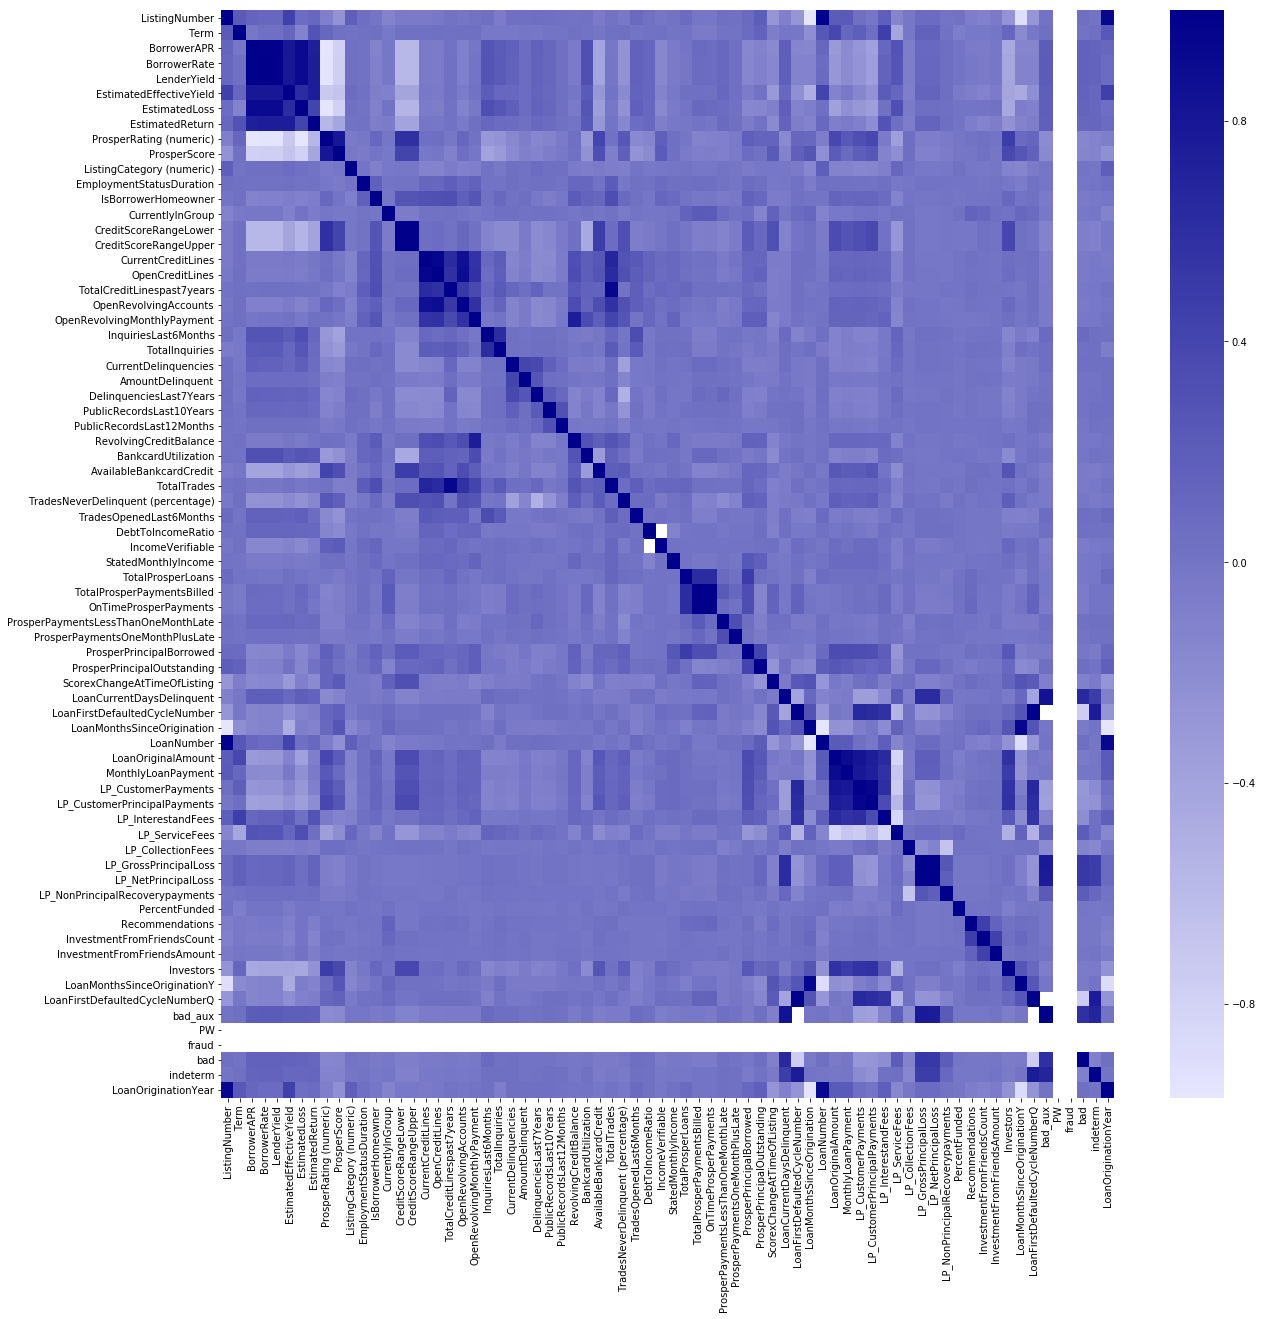

In [40]:
matriz_corr = df_it.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(round(matriz_corr, 2), cmap = sns.light_palette("darkblue", as_cmap=True))